# Use of foscat to forecast ECMWF global information

This notebook ....

## TODO:

- Problem while using statistics of the previous timestep, should compress dimensinality of foscat

## Installation of required packages

In [1]:
!pip install foscat==3.0.44

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import netCDF4 as nc
import foscat.scat_cov as sc
import foscat.Synthesis as synthe

### Choose the resolution

In [2]:
nside=64

In [3]:
import gcsfs
import xarray
gcs = gcsfs.GCSFileSystem(token='anon')

era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)
full_era5

<xarray.Dataset>
Dimensions:                                                          (
                                                                      time: 1089864,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 ...
  * level                                                            (level) int64 ...
  * longitude                                                        (longitude) float32 ...
  * time                                                             (time) datetime64[ns] ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 ...
    zero_degree_level                                                (time, latitude, longitude) float32 ...

In [4]:
specific_humidity=full_era5['specific_humidity'].sel(level=20)
specific_humidity

<xarray.DataArray 'specific_humidity' (time: 1089864, latitude: 721,
                                       longitude: 1440)>
[1131540399360 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    level      int64 20
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1900-01-01 ... 2024-04-30T23:00:00
Attributes:
    long_name:      Specific humidity
    short_name:     q
    standard_name:  specific_humidity
    units:          kg kg**-1

In [5]:
from scipy.interpolate import RegularGridInterpolator

# convert the input data in a nside=nside healpix map based on repixelisation at l_nside
def to_Healpix(arr_val,itime,nside,l_nside=512):
    
    latitude=(90.0-arr_val.latitude.compute().to_numpy())/180.*np.pi
    longitude=(360.0-arr_val.longitude.compute().to_numpy())/180.*np.pi
    im=arr_val.sel(time=itime).compute().to_numpy()
    
    xsize,ysize=im.shape

    # Define the new row and column to be added to prepare the interpolation
    new_row = im[0:1,:]  # A new row with N elements (the other longitude)
    new_column = np.concatenate([im[:,0:1],im[-2:-1,0:1]],0)  # A new column with N+1 elements to add previous latitude

    # Add the new row to the array
    im = np.vstack([im, new_row])
    longitude = np.concatenate([longitude,2*longitude[-1:]-longitude[-2:-1]],0)
    latitude = np.concatenate([latitude,2*latitude[-1:]-latitude[-2:-1]],0)

    # Add the new column to the array with the new row
    im = np.hstack([im, new_column])

    # Create an interpolator
    interpolator = RegularGridInterpolator((latitude,longitude), im)

    # List of healpix coordinate to interpol
    colatitude,longitude = hp.pix2ang(l_nside,np.arange(12*l_nside**2),nest=True)
    coords = np.concatenate([colatitude,longitude],0).reshape(2,colatitude.shape[0]).T

    # Perform the interpolation
    heal_im = interpolator(coords)

    #reduce the final map to the expected resolution
    if nside>l_nside:
        th,ph=hp.pix2ang(nside,np.arange(12*nside**2),nest=True)
        heal_im=hp.get_interp_val(heal_im,th,ph,nest=True)
    else:
        heal_im=np.mean(heal_im.reshape(12*nside**2,(l_nside//nside)**2),1)

    return heal_im

In [6]:
heal_im_0=to_Healpix(specific_humidity,'2024-04-30T12:00:00.000000000',nside)
heal_im_1=to_Healpix(specific_humidity,'2024-04-29T12:00:00.000000000',nside)
heal_im_2=to_Healpix(specific_humidity,'2024-04-28T12:00:00.000000000',nside)

amp_shum=np.std(heal_im_0)
mean_shum=np.median(heal_im_0)

heal_im_0=(heal_im_0-mean_shum)/amp_shum
heal_im_1=(heal_im_1-mean_shum)/amp_shum
heal_im_2=(heal_im_2-mean_shum)/amp_shum

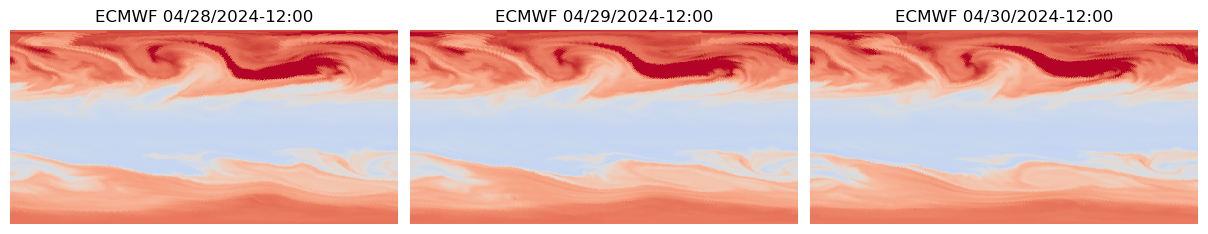

In [7]:
plt.figure(figsize=(12,4))
hp.cartview(heal_im_0,cmap='coolwarm',nest=True,hold=False,sub=(1,3,1),
            title='ECMWF 04/28/2024-12:00',min=-3,max=3,cbar=False)
hp.cartview(heal_im_1,cmap='coolwarm',nest=True,hold=False,sub=(1,3,2),
            title='ECMWF 04/29/2024-12:00',min=-3,max=3,cbar=False)
hp.cartview(heal_im_2,cmap='coolwarm',nest=True,hold=False,sub=(1,3,3),
            title='ECMWF 04/30/2024-12:00',min=-3,max=3,cbar=False)

### Initialise FOSCAT scattering covariance description

In [8]:
scat_op=sc.funct(NORIENT=4,          # define the number of wavelet orientation
                KERNELSZ=3,  #KERNELSZ,  # define the kernel size
                JmaxDelta=0,        # The used Jmax is Jmax-JmaxDelta
                all_type='float64')

          START FOSCAT CONFIGURATION


2024-07-23 16:00:17.913305: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
==                                                        ==
==                                                        ==
==     RUN ON GPU Rank 0 : /device:GPU:0                          ==
==                                                        ==
==                                                        ==
Init Wave  2
Init Wave  4
Init Wave  8
Init Wave  16
Init Wave  32


2024-07-23 16:00:20.864288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:30:00.0, compute capability: 8.0


### Compute the cross statistics between two times

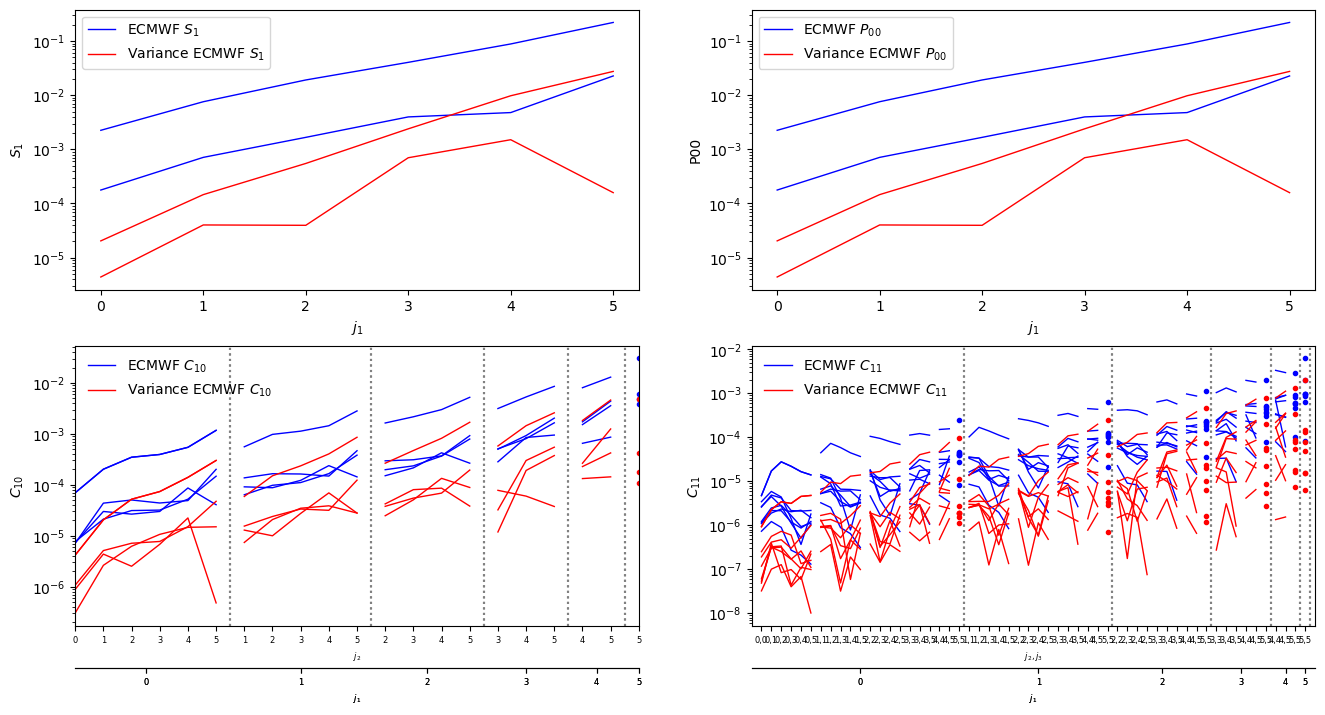

In [13]:
ref,sref=scat_op.eval(heal_im_0,image2=heal_im_1,calc_var=True)
ref=ref.fft_ang()
sref=sref.fft_ang()
ref.plot(name='ECMWF',color='b')
sref.plot(name='Variance ECMWF',color='r',hold=False)

### Define the loss function

In [14]:
def The_loss(u,scat_operator,args):
    imref= args[0]
    ref  = args[1]
    sref = args[2]
    mask = args[3]

    # compute scattering covariance of the current synthetised map called u
    learn=scat_operator.eval(imref,image2=u,mask=mask).fft_ang()

    # make the difference withe the reference coordinates
    loss=scat_operator.reduce_distance(learn,ref,sigma=sref)

    return(loss)

### Build the synthesis model

In [15]:
loss1=synthe.Loss(The_loss,scat_op,heal_im_1,ref,sref,None)

sy = synthe.Synthesis([loss1])

### Run the synthesis

In [25]:
imap=heal_im_1

omap=sy.run(imap,
            EVAL_FREQUENCY=100,
            NUM_EPOCHS = 3000).numpy()

Total number of loss  1
Itt      0 L=  1.36e+06 (  1.36e+06 ) 0.064s 
Itt    100 L=       129 (       129 ) 7.463s 
Itt    200 L=      72.5 (      72.5 ) 7.354s 
Itt    300 L=      50.4 (      50.4 ) 7.316s 
Itt    400 L=      33.7 (      33.7 ) 7.334s 
Itt    500 L=      28.6 (      28.6 ) 7.304s 
Itt    600 L=      24.8 (      24.8 ) 7.130s 
Itt    700 L=      21.9 (      21.9 ) 7.295s 
Itt    800 L=      19.9 (      19.9 ) 7.693s 
Itt    900 L=      18.4 (      18.4 ) 7.489s 
Itt   1000 L=      16.9 (      16.9 ) 7.302s 
Itt   1100 L=      15.6 (      15.6 ) 7.243s 
Itt   1200 L=      14.5 (      14.5 ) 7.015s 
Itt   1300 L=      13.4 (      13.4 ) 6.896s 
Itt   1400 L=      12.4 (      12.4 ) 7.272s 
Itt   1500 L=      11.7 (      11.7 ) 7.001s 
Itt   1600 L=      10.8 (      10.8 ) 7.555s 
Itt   1700 L=      10.4 (      10.4 ) 7.124s 
Itt   1800 L=      10.1 (      10.1 ) 7.467s 
Itt   1900 L=      9.75 (      9.75 ) 7.648s 
Itt   2000 L=      9.48 (      9.48 ) 7.404s 
Itt   2100

### Plot the results

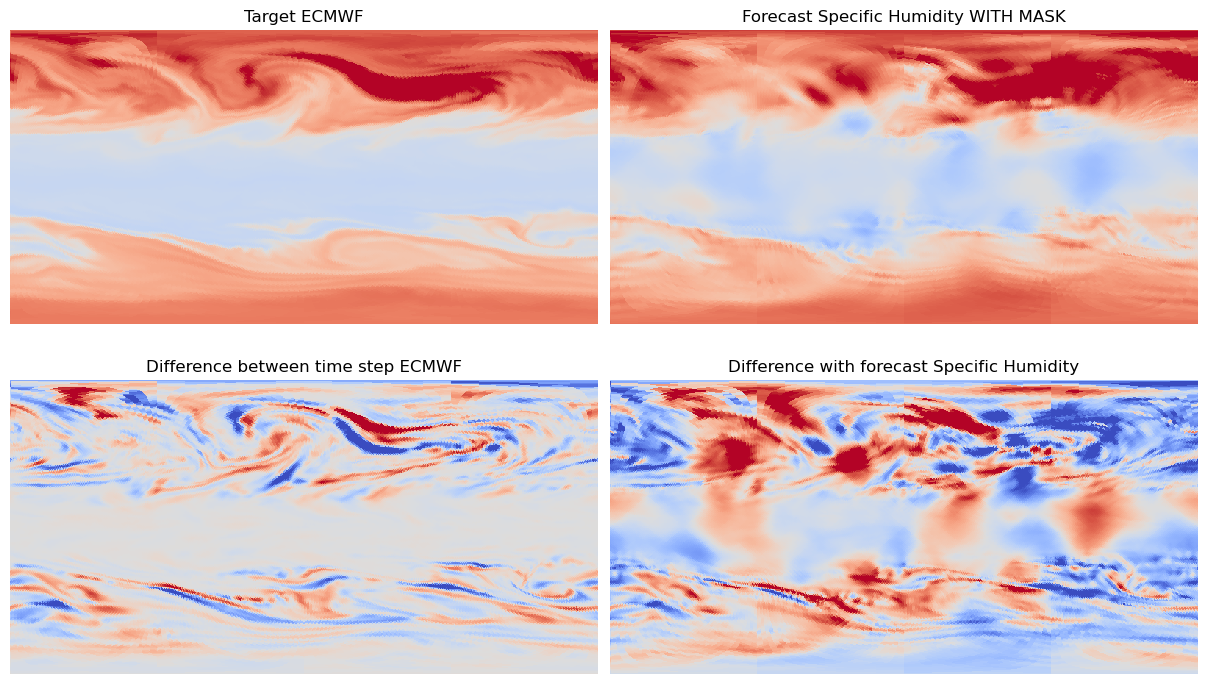

In [26]:
plt.figure(figsize=(12,7))
hp.cartview(heal_im_2,cmap='coolwarm',nest=True,title='Target ECMWF',
            hold=False,sub=(2,2,1),cbar=False,min=-3,max=3)
hp.cartview(omap,cmap='coolwarm',nest=True,title='Forecast Specific Humidity WITH MASK',
            hold=False,sub=(2,2,2),cbar=False,min=-3,max=3)
hp.cartview(heal_im_2-heal_im_1,cmap='coolwarm',nest=True,title='Difference between time step ECMWF',
            hold=False,sub=(2,2,3),cbar=False,min=-1,max=1)
hp.cartview(heal_im_2-omap,cmap='coolwarm',nest=True,title='Difference with forecast Specific Humidity',
            hold=False,sub=(2,2,4),cbar=False,min=-1,max=1)

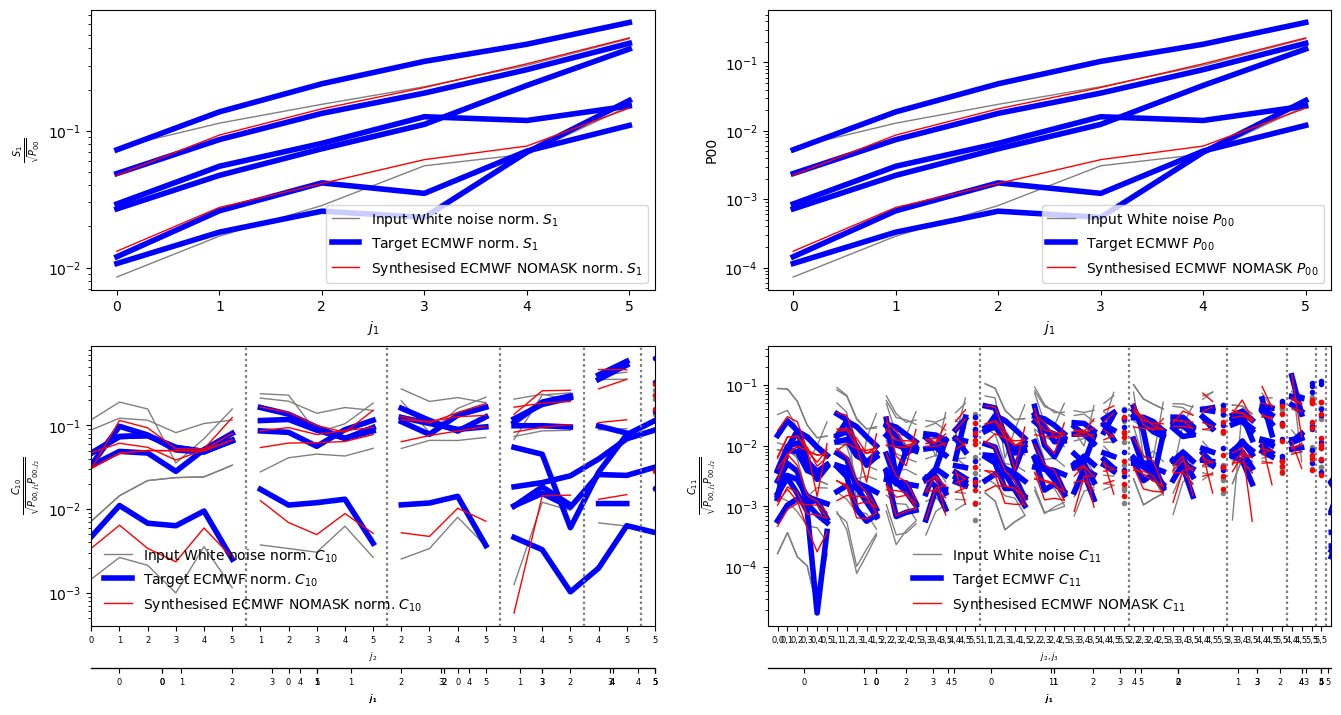

In [27]:
synth=scat_op.eval(heal_im_1,image2=omap).fft_ang()
inscat=scat_op.eval(heal_im_1,image2=imap).fft_ang()
inscat.plot(name='Input White noise',color='grey',norm=True)
ref.plot(name='Target ECMWF',color='b',norm=True,lw=4,hold=False)
synth.plot(name='Synthesised ECMWF NOMASK',color='r',hold=False,norm=True)

In [28]:
mask=np.ones([3,12*nside**2])
th,ph=hp.pix2ang(nside,np.arange(12*nside**2),nest=True)
mask[1]=hp.smoothing((th>=np.pi/3)*(th<=2*np.pi/3),5/180.*np.pi,nest=True)
mask[0]=(th<np.pi/3)*(1.0-mask[1])
mask[2]=(th>2*np.pi/3)*(1.0-mask[1])

del th
del ph

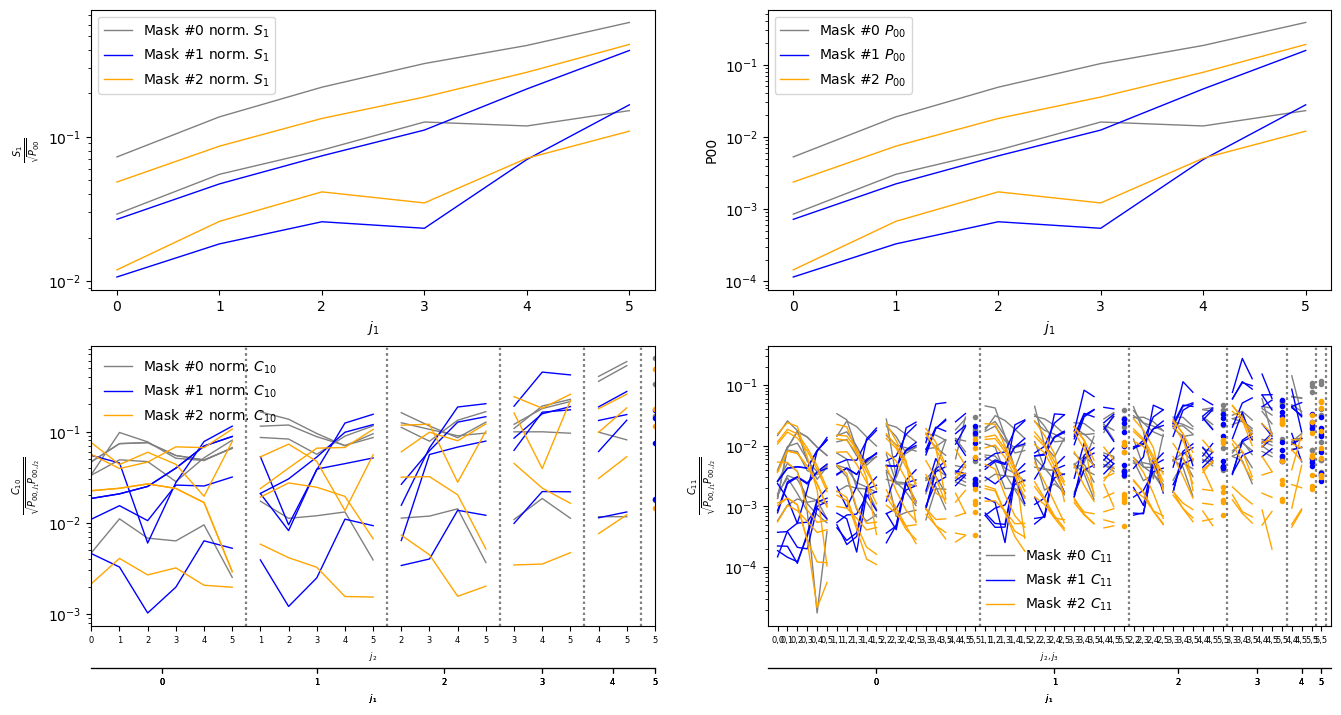

In [29]:
color=['grey','b','orange']
plt.figure(figsize=(16,8))
for k in range(3):
    scat_op.eval(heal_im_0,image2=heal_im_1,mask=mask[k:1+k,:]).fft_ang().plot(color=color[k],name='Mask #%d'%(k),hold=False,norm=True)

In [30]:
ref,sref=scat_op.eval(heal_im_0,image2=heal_im_1,calc_var=True,mask=mask)
ref=ref.fft_ang()
sref=sref.fft_ang()

In [31]:
loss1=synthe.Loss(The_loss,scat_op,heal_im_1,ref,sref,mask)

sy = synthe.Synthesis([loss1])

In [ ]:
imap=heal_im_1

omap=sy.run(imap,
            EVAL_FREQUENCY=100,
            NUM_EPOCHS = 3000).numpy()

Total number of loss  1
 Run [PROC=0000] on GPU /device:GPU:0
Itt      0 L=  1.36e+06 (  1.36e+06 ) 23.778s 
Itt    100 L=       124 (       124 ) 7.227s 
Itt    200 L=      77.6 (      77.6 ) 7.439s 
Itt    300 L=      54.6 (      54.6 ) 7.368s 
Itt    400 L=      35.6 (      35.6 ) 7.067s 
Itt    500 L=      29.9 (      29.9 ) 7.376s 
Itt    600 L=      26.8 (      26.8 ) 6.979s 
Itt    700 L=        23 (        23 ) 7.557s 
Itt    800 L=      20.9 (      20.9 ) 7.430s 
Itt    900 L=      20.1 (      20.1 ) 7.304s 
Itt   1000 L=      18.8 (      18.8 ) 7.194s 
Itt   1100 L=      17.7 (      17.7 ) 6.953s 
Itt   1200 L=      16.5 (      16.5 ) 6.851s 
Itt   1300 L=      15.1 (      15.1 ) 7.305s 
Itt   1400 L=      13.6 (      13.6 ) 7.822s 
Itt   1500 L=      12.4 (      12.4 ) 7.367s 
Itt   1600 L=      11.6 (      11.6 ) 7.214s 
Itt   1700 L=      11.1 (      11.1 ) 7.586s 
Itt   1800 L=      10.5 (      10.5 ) 7.400s 
Itt   1900 L=      9.96 (      9.96 ) 7.377s 
Itt   2000 L=    

In [ ]:
plt.figure(figsize=(12,7))
hp.cartview(heal_im_2,cmap='coolwarm',nest=True,title='Target ECMWF',
            hold=False,sub=(2,2,1),cbar=False,min=-3,max=3)
hp.cartview(omap,cmap='coolwarm',nest=True,title='Forecast Specific Humidity WITH MASK',
            hold=False,sub=(2,2,2),cbar=False,min=-3,max=3)
hp.cartview(heal_im_2-heal_im_1,cmap='coolwarm',nest=True,title='Difference between time step ECMWF',
            hold=False,sub=(2,2,3),cbar=False,min=-1,max=1)
hp.cartview(heal_im_2-omap,cmap='coolwarm',nest=True,title='Difference with forecast Specific Humidity',
            hold=False,sub=(2,2,4),cbar=False,min=-1,max=1)